In [1]:
# seventeen fMRI data files from AG

In [2]:
%matplotlib inline
import deepdish as dd
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.patches as patches
import numpy as np
import brainiak.eventseg.event
from scipy import stats
from scipy.stats import norm, zscore, pearsonr
from scipy.signal import gaussian, convolve
from sklearn import decomposition
import seaborn as sns 

In [3]:
import warnings
import sys 
import os    
import scipy.io

In [4]:
from easyesn.optimizers import GradientOptimizer
from easyesn import PredictionESN
from easyesn.optimizers import GridSearchOptimizer
from easyesn import helper as hlp

Using Numpy backend.


dict_keys(['__header__', '__version__', '__globals__', 'keptvox', 'rdata'])
(481, 946)


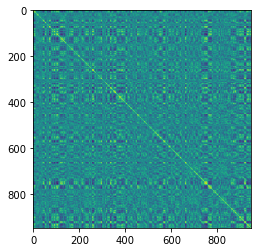

In [5]:
data = scipy.io.loadmat('data_mat/s1/sherlock_movie/pmc_nn_sherlock_movie_s1.mat')
print(data.keys())
pmc_data = data['rdata'][:,:946]
print(pmc_data.shape)
plt.imshow(np.corrcoef(pmc_data.T))

In [6]:
#reservoir setup

vectorDim = 100
numNode = 1000
reps = 16
SherlockInputData = np.load('sherlock-input-data.npy')
in_small = np.load('CH2020_50/in_small.npy')
out_small = np.load('CH2020_50/out_small.npy')

In [7]:
sherlock_movies = np.load('Sherlock_AG_movie.npy')

(16, 946, 4230)


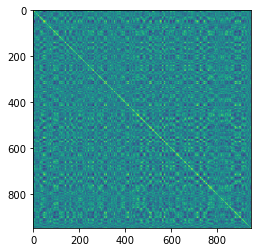

In [8]:
print(sherlock_movies.shape)
#plt.imshow(np.corrcoef(BOLD[:,:,1].T))
plt.imshow(np.corrcoef(sherlock_movies[15,:,:]))

In [9]:
D3 = dd.io.load('sherlock.h5')
print(D3.keys())
BOLD = D3['BOLD']
COORDS = D3['coords']
print(BOLD.shape)
#print(COORDS)

dict_keys(['BOLD', 'coords', 'human_bounds'])
(141, 1976, 17)


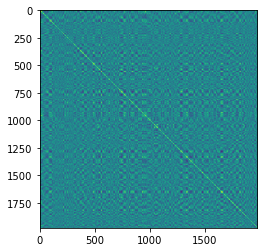

In [10]:
plt.imshow(np.corrcoef(BOLD[:,:,1].T))

In [11]:
D = dd.io.load('sherlock_h5_data/AG_movie_1recall.h5')
recall = D['recall']


dict_keys(['movie', 'movie_labels', 'recall', 'recall_labels'])
(1253, 1009)


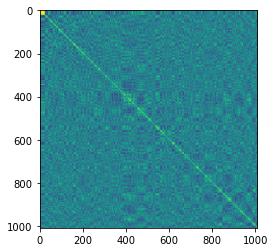

In [12]:
plt.imshow(np.corrcoef(recall.T))
print(D.keys())
print(recall.shape)

In [13]:
Data = dd.io.load('sherlock_dir/AG_movie_recall.h5')


In [14]:
print(Data.keys())
print(D.keys())

dict_keys(['movie', 'movie_labels', 'recall', 'recall_labels'])
dict_keys(['movie', 'movie_labels', 'recall', 'recall_labels'])


In [15]:
recall = Data['recall']

In [16]:
movie = Data['movie']

In [17]:
print(recall.keys())

dict_keys(['0', '1', '10', '11', '12', '13', '14', '15', '16', '2', '3', '4', '5', '6', '7', '8', '9'])


(1253, 713)


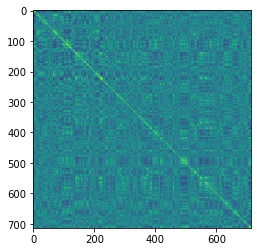

In [18]:
AG1 = recall['2']
print(AG1.shape)
plt.imshow(np.corrcoef(AG1.T))

In [19]:
file_count = 0
AG_sherlock_subject = recall[str(file_count)]


In [20]:
segno=40  # k, or the number of segments we look for

fmri_bounds = np.zeros((17,segno-1))
reservoir_bounds = np.zeros((17,segno-1))


In [21]:
# this is a loop on 10 subjects and reservoirs that does the HMM segmentation - it is to see the variability!!
ev11 = brainiak.eventseg.event.EventSegment(segno)

for file_count in range(reps):
    # set the seed
    np.random.seed(file_count)

    # set up the reservoir
    # leakingRate=0.2 changing too fast, mutliple with 0.05; changed
    esn = PredictionESN(n_input=vectorDim, n_output=vectorDim, n_reservoir=numNode, leakingRate=0.05, 
                        regressionParameters=[1e-2], solver="lsqr", feedback=False)

    # train the reervoir with a new seed
    esn.fit(in_small, out_small, transientTime="Auto", verbose=1)

    #run the reservoir
    reservoirStatesBuffer = np.empty((0,numNode))
    prediction,reservoirStatesBuffer  = esn.predict(SherlockInputData)
    reservoirStatesBuffer = reservoirStatesBuffer.T
    print(reservoirStatesBuffer.shape)
    reservoirStatesBuffer = reservoirStatesBuffer[:,101:]
    print(reservoirStatesBuffer.shape)
    print(prediction.shape)

    if file_count == 0:
        reservoir_averages = reservoirStatesBuffer
    else:
        reservoir_averages = reservoir_averages + reservoirStatesBuffer
        
    ev11.fit(reservoirStatesBuffer)
    bounds11 = np.where(np.diff(np.argmax(ev11.segments_[0], axis=1)))[0]
    print(bounds11)
    reservoir_bounds[file_count,:]=bounds11    
    



    #fmri
    #data = scipy.io.loadmat('data_mat/s'+str(file_count+1)+'/sherlock_movie/pmc_nn_sherlock_movie_s'+str(file_count+1)+'.mat')
    #pmc_data = data['rdata'][:,:946].T
    
    pmc_data = sherlock_movies[file_count,:,:]

    #AG_sherlock_subject = BOLD[:,:,file_count]
    #AG_sherlock_subject = recall[str(file_count)]
    #ev11.fit(AG_sherlock_subject.T)
    ev11.fit(pmc_data)
    bounds11 = np.where(np.diff(np.argmax(ev11.segments_[0], axis=1)))[0]
    print(bounds11)
    fmri_bounds[file_count,:]=bounds11
    
    
    if file_count == 0:
        fmri_averages = pmc_data
    else:
        fmri_averages = fmri_averages + pmc_data



    
#fMRI bounds  [ 32  70 115 164 204 247 286 319 368] 400
#Reservoir bounds  [ 84 133 198 257 341 412 515 578 631] 682


   

100% (9603 of 9603) |####################| Elapsed Time: 0:00:07 Time:  0:00:07


(1251, 1101)
(1251, 1000)
(1251, 100)
[  21   49   81  105  144  183  215  243  281  305  334  367  402  441
  464  498  520  547  574  613  641  677  719  761  792  819  854  877
  908  931  972 1019 1053 1080 1109 1141 1163 1183 1212]
[ 25  46  68  83 110 123 146 171 196 227 254 277 291 311 335 361 381 398
 431 467 492 508 526 553 586 616 635 658 678 716 731 759 780 809 839 859
 875 895 916]


100% (9615 of 9615) |####################| Elapsed Time: 0:00:06 Time:  0:00:06


(1251, 1101)
(1251, 1000)
(1251, 100)
[  23   51   97  119  145  189  215  244  280  304  334  366  398  442
  465  499  520  548  574  616  645  676  717  751  791  815  853  875
  900  927  983 1018 1053 1080 1108 1141 1162 1183 1212]
[ 19  39  75  85 110 133 164 186 208 221 250 264 299 337 357 383 402 429
 445 475 504 526 538 551 566 599 638 663 700 716 738 756 780 806 821 857
 870 889 924]


100% (9606 of 9606) |####################| Elapsed Time: 0:00:09 Time:  0:00:09


(1251, 1101)
(1251, 1000)
(1251, 100)
[  21   48   81  105  143  186  214  239  278  304  334  367  402  440
  463  499  520  546  573  614  642  675  717  751  791  816  854  878
  922  958  987 1020 1053 1080 1107 1140 1162 1182 1211]
[ 26  38  61  85 111 134 157 174 186 230 254 278 303 320 340 361 383 400
 441 465 487 518 544 564 589 617 639 661 700 721 741 763 783 802 841 858
 872 893 921]


100% (9615 of 9615) |####################| Elapsed Time: 0:00:07 Time:  0:00:07


(1251, 1101)
(1251, 1000)
(1251, 100)
[  22   51   95  119  145  184  214  242  280  305  334  368  401  440
  461  498  520  546  573  614  643  676  718  757  791  813  844  872
  898  925  972 1017 1053 1079 1108 1140 1162 1183 1212]
[ 22  38  55  85 110 136 159 190 229 254 268 279 304 326 346 367 393 424
 446 467 500 523 548 571 596 618 634 672 701 717 730 767 789 805 842 859
 874 892 922]


100% (9611 of 9611) |####################| Elapsed Time: 0:00:07 Time:  0:00:07


(1251, 1101)
(1251, 1000)
(1251, 100)
[  22   51   97  120  146  183  214  239  280  304  334  367  401  440
  461  499  520  547  574  614  643  678  717  754  791  813  843  870
  897  925  970 1017 1053 1079 1109 1142 1165 1191 1214]
[ 12  39  67  82 110 133 145 173 199 226 246 272 307 333 356 368 386 423
 474 496 512 536 547 563 590 617 637 668 697 713 739 757 779 801 829 858
 875 892 926]


100% (9619 of 9619) |####################| Elapsed Time: 0:00:06 Time:  0:00:06


(1251, 1101)
(1251, 1000)
(1251, 100)
[  21   50   95  119  145  188  215  246  280  304  334  367  402  441
  462  499  520  546  572  614  642  676  718  760  791  813  846  873
  898  926  974 1019 1053 1079 1109 1141 1163 1184 1212]
[ 26  38  61  92 110 132 156 184 200 228 254 273 303 324 352 364 381 416
 446 471 496 507 526 551 569 604 618 660 713 731 755 778 795 825 842 859
 876 897 925]


100% (9611 of 9611) |####################| Elapsed Time: 0:00:07 Time:  0:00:07


(1251, 1101)
(1251, 1000)
(1251, 100)
[  21   49   82  109  144  181  212  238  276  304  334  367  400  439
  461  498  520  547  574  613  642  676  718  758  792  816  855  889
  923  958  987 1020 1053 1079 1109 1141 1163 1184 1212]
[ 25  38  57  85 110 133 161 195 219 243 256 280 301 328 350 381 396 428
 444 464 479 526 546 564 587 618 636 649 661 697 728 762 782 800 831 858
 876 897 916]


100% (9608 of 9608) |####################| Elapsed Time: 0:00:07 Time:  0:00:07


(1251, 1101)
(1251, 1000)
(1251, 100)
[  23   52   96  120  145  182  210  238  279  305  334  367  402  441
  464  499  520  546  575  614  644  676  718  753  791  813  843  870
  894  924  972 1018 1053 1079 1108 1140 1162 1182 1211]
[ 26  38  72  87 109 134 165 194 224 244 257 273 306 324 350 368 406 421
 443 472 497 525 552 576 600 616 643 673 706 719 736 763 780 808 842 864
 880 890 923]


100% (9600 of 9600) |####################| Elapsed Time: 0:00:07 Time:  0:00:07


(1251, 1101)
(1251, 1000)
(1251, 100)
[  22   50   95  119  145  183  213  239  276  304  334  367  401  441
  465  499  521  547  573  615  644  676  718  752  791  813  845  873
  900  927  981 1019 1053 1079 1109 1143 1169 1198 1222]
[ 23  41  73  84 110 151 172 193 207 223 259 280 301 322 358 379 397 444
 464 493 506 540 550 563 595 615 636 664 681 699 724 758 775 799 839 862
 893 912 921]


100% (9617 of 9617) |####################| Elapsed Time: 0:00:10 Time:  0:00:10


(1251, 1101)
(1251, 1000)
(1251, 100)
[  23   52   97  120  145  183  213  238  276  304  334  368  401  441
  462  498  520  547  574  615  644  676  717  752  791  813  844  870
  899  925  958  989 1029 1079 1108 1141 1164 1187 1213]
[  7  37  61  86 110 132 173 184 195 229 253 265 297 318 343 368 396 416
 442 463 494 513 545 562 581 619 643 668 702 716 737 761 780 831 863 876
 892 921 936]


100% (9587 of 9587) |####################| Elapsed Time: 0:00:08 Time:  0:00:08


(1251, 1101)
(1251, 1000)
(1251, 100)
[  23   51   96  120  145  180  208  238  277  304  334  368  401  440
  461  499  520  546  573  614  644  675  718  757  792  812  844  869
  898  924  958  988 1019 1053 1080 1109 1143 1176 1210]
[ 22  38  67  86 110 136 158 175 194 219 257 279 312 334 362 379 398 422
 444 470 500 514 549 563 588 618 635 674 701 724 743 762 778 804 830 848
 872 892 913]


100% (9620 of 9620) |####################| Elapsed Time: 0:00:07 Time:  0:00:07


(1251, 1101)
(1251, 1000)
(1251, 100)
[  20   47   81  107  144  184  213  239  279  304  335  367  401  441
  465  499  521  547  573  614  642  676  718  755  791  818  853  875
  899  925  973 1018 1053 1079 1109 1141 1164 1184 1212]
[ 35  55  84  98 110 133 157 174 189 229 251 268 302 329 364 381 398 413
 444 476 495 534 547 561 598 629 664 680 700 723 756 777 798 824 852 868
 876 891 920]


100% (9616 of 9616) |####################| Elapsed Time: 0:00:07 Time:  0:00:07


(1251, 1101)
(1251, 1000)
(1251, 100)
[  22   51   96  120  145  182  213  240  279  304  333  367  402  441
  463  499  520  547  574  614  642  676  717  751  791  816  854  878
  923  957  987 1020 1053 1080 1107 1139 1162 1181 1211]
[ 26  38  56  80 109 127 142 171 197 233 256 282 302 329 346 363 397 443
 464 490 513 536 575 583 612 643 657 699 723 741 765 772 790 816 843 865
 885 910 923]


100% (9591 of 9591) |####################| Elapsed Time: 0:00:07 Time:  0:00:07


(1251, 1101)
(1251, 1000)
(1251, 100)
[  22   51   96  119  145  181  212  238  275  304  334  368  401  441
  465  499  520  546  572  614  641  675  717  752  791  814  851  874
  899  924  958  988 1025 1079 1108 1142 1162 1182 1212]
[ 13  32  49  82 119 156 175 202 224 236 255 270 302 331 358 380 401 426
 457 491 506 533 546 560 579 616 643 658 705 716 740 759 781 809 842 863
 881 894 924]


100% (9596 of 9596) |####################| Elapsed Time: 0:00:08 Time:  0:00:08


(1251, 1101)
(1251, 1000)
(1251, 100)
[  21   46   79  104  144  189  215  240  278  304  334  367  401  441
  463  499  520  547  573  614  643  676  717  751  791  813  844  871
  899  925  970 1018 1053 1079 1109 1141 1164 1185 1213]
[ 23  37  61  83 109 133 177 199 226 251 269 286 304 317 330 360 381 396
 424 444 469 505 535 565 585 621 647 670 700 718 731 747 765 781 813 853
 873 895 925]


100% (9592 of 9592) |####################| Elapsed Time: 0:00:06 Time:  0:00:06


(1251, 1101)
(1251, 1000)
(1251, 100)
[  23   52   96  120  145  183  212  238  277  304  334  366  401  440
  461  499  520  547  573  614  642  675  719  759  791  812  843  868
  893  925  971 1019 1053 1080 1110 1143 1175 1199 1226]
[ 27  41  60  85 111 134 144 192 216 247 265 278 303 335 362 380 399 420
 442 463 502 515 529 558 591 617 642 668 682 700 722 756 782 805 832 859
 873 903 927]


In [22]:

reservoir_averages = reservoir_averages/reps
fmri_averages = fmri_averages/reps

In [23]:
np.save('Exp2-sherlock-res-40.npy',reservoir_averages)
np.save('Exp2-sherlock-fmri-40.npy',fmri_averages)

In [24]:
ev_fmri = brainiak.eventseg.event.EventSegment(segno)
ev_fmri.fit(fmri_averages)

ev_reservoir = brainiak.eventseg.event.EventSegment(segno)
ev_reservoir.fit(reservoir_averages)


EventSegment(event_chains=array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0.]),
             n_events=40)

In [112]:
reservoir_averages_norm = np.zeros((1251,1000))
fmri_averages_norm = np.zeros((946,4230))

In [121]:
for j in range(reservoir_averages.shape[1]):
    mean = reservoir_averages[:,j].mean()
    if abs(mean) > 0.001:
        reservoir_averages_norm[:,j] = reservoir_averages[:,j]/mean 
    else:
        reservoir_averages_norm[:,j] = reservoir_averages[:,j]

In [122]:
for j in range(fmri_averages.shape[1]):
    mean = fmri_averages[:,j].mean()
    if abs(mean) > 10:
        fmri_averages_norm[:,j] = fmri_averages[:,j]/mean      
    else:
        fmri_averages_norm[:,j] = fmri_averages[:,j]

In [32]:
fmri_bounds_means= np.zeros(segno-1)
reservoir_bounds_means= np.zeros(segno-1)


for i in range(segno-1):
    fmri_bounds_means[i] = fmri_bounds[:reps,i].mean()
    reservoir_bounds_means[i] =reservoir_bounds[:reps,i].mean()

fMRI bounds  [ 22.3125  39.5625  64.1875  85.5    110.5    135.     159.4375 184.8125
 206.8125 233.75   256.5    275.25   302.3125 326.125  350.5625 371.4375
 393.4375 419.9375 446.9375 472.9375 497.     522.4375 543.9375 563.
 588.25   617.6875 640.4375 667.8125 696.875  716.6875 738.5    762.3125
 782.3125 807.8125 837.5625 860.375  877.6875 897.6875 922.625 ]
Reservoir bounds  [  21.875    50.0625   91.25    115.3125  144.6875  183.8125  213.
  239.9375  278.1875  304.1875  334.      367.125   401.0625  440.625
  462.875   498.75    520.125   546.6875  573.375   614.125   642.75
  675.9375  717.6875  754.625   791.1875  814.3125  848.125   873.875
  903.125   931.625   973.3125 1012.9375 1047.625  1077.6875 1106.6875
 1139.0625 1162.8125 1185.25   1213.4375]


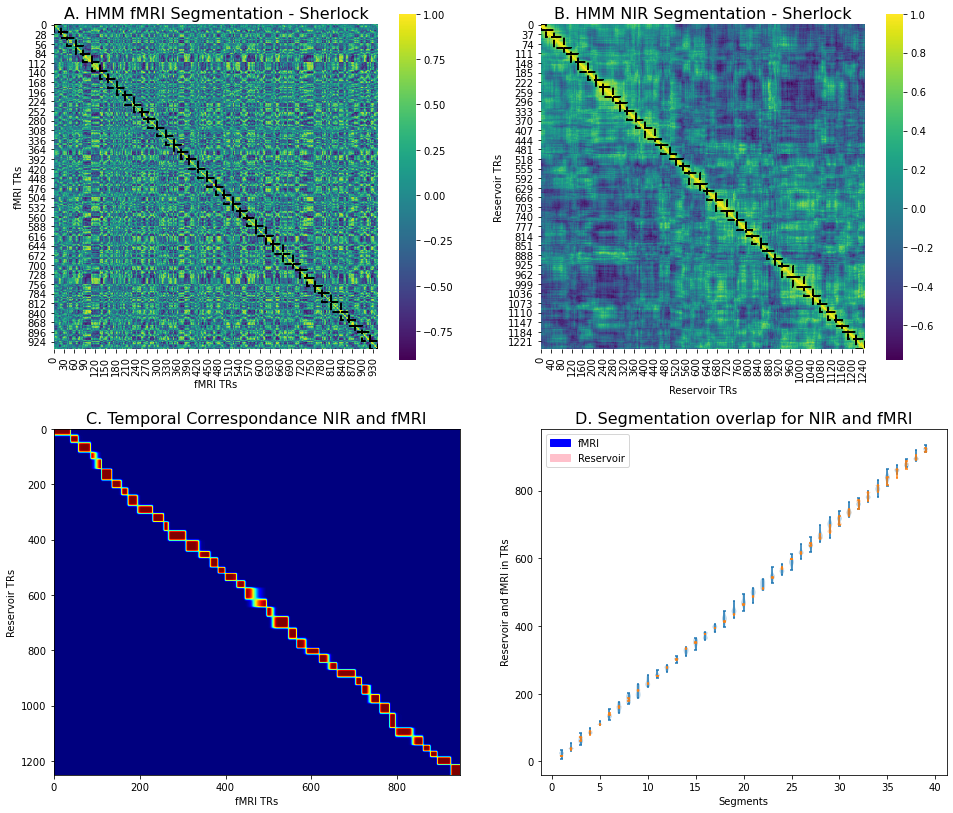

In [124]:
plt.figure(figsize=(16,14))
plt.subplot(2,2,1)
color='jet'
edge='black'
scale1=0.5
scale2=0.9
nTR=946

#plt.imshow(np.corrcoef(fmri_averages), cmap=color, vmin = scale1, origin = 'lower')
#plt.imshow(np.corrcoef(BOLD.mean(2).T))

#sns.heatmap(np.corrcoef(fmri_averages_norm[400:800,400:800]),cmap='viridis', square=True)
sns.heatmap(np.corrcoef(fmri_averages_norm),cmap='viridis', square=True)


#bounds = np.where(np.diff(np.argmax(ev_fmri.segments_[0], axis=1)))[0]
bounds = fmri_bounds_means
ax = plt.gca()
bounds_aug = np.concatenate(([0],bounds,[nTR]))
for i in range(len(bounds_aug)-1):
    rect = patches.Rectangle((bounds_aug[i],bounds_aug[i]),bounds_aug[i+1]-bounds_aug[i],bounds_aug[i+1]-bounds_aug[i],linewidth=2,linestyle='--', edgecolor=edge,facecolor='none')
    ax.add_patch(rect)
    
print('fMRI bounds ', bounds)
plt.xlabel('fMRI TRs')
plt.ylabel('fMRI TRs')

plt.title('A. HMM fMRI Segmentation - Sherlock', fontsize = 16)


plt.subplot(2,2,2)

#sns.heatmap(np.corrcoef(reservoir_averages_norm[528:1056,528:1056]),cmap='viridis', square=True)
sns.heatmap(np.corrcoef(reservoir_averages_norm),cmap='viridis', square=True)


nTR=1251
#bounds = np.where(np.diff(np.argmax(ev_reservoir.segments_[0], axis=1)))[0]
bounds = reservoir_bounds_means
ax = plt.gca()
bounds_aug = np.concatenate(([0],bounds,[nTR]))
for i in range(len(bounds_aug)-1):
    rect = patches.Rectangle((bounds_aug[i],bounds_aug[i]),bounds_aug[i+1]-bounds_aug[i],bounds_aug[i+1]-bounds_aug[i],linewidth=2,linestyle='--', edgecolor=edge,facecolor='none')
    ax.add_patch(rect)

print('Reservoir bounds ', bounds)    
plt.xlabel('Reservoir TRs')
plt.ylabel('Reservoir TRs')

plt.title('B. HMM NIR Segmentation - Sherlock', fontsize = 16)


plt.subplot(2,2,3)

#plt.imshow(np.dot(ev_fmri.segments_[0], ev_reservoir.segments_[0].T).T,aspect='auto',cmap='jet')
plt.imshow(np.dot(ev_fmri.segments_[0], ev_reservoir.segments_[0].T).T,aspect='auto',cmap='jet')


plt.xlabel('fMRI TRs')
plt.ylabel('Reservoir TRs')

plt.title('C. Temporal Correspondance NIR and fMRI', fontsize = 16)



plt.subplot(2,2,4)

#plt.imshow(np.dot(ev_fmri.segments_[0], ev_reservoir.segments_[0].T).T,aspect='auto',cmap='jet')#origin='lower',
plt.violinplot(fmri_bounds[:reps])
plt.violinplot(reservoir_bounds[:reps]/1251*946)

plt.xlabel('Segments')
plt.ylabel('Reservoir and fMRI in TRs')

red_patch = patches.Patch(color='pink', label='Reservoir')
#plt.legend(handles=[red_patch], loc='upper left')

blue_patch = patches.Patch(color='blue', label='fMRI')
plt.legend(handles=[blue_patch, red_patch], loc='upper left')

plt.title('D. Segmentation overlap for NIR and fMRI', fontsize = 16)




#fig.tight_layout()
plt.savefig('Exp2-replication-sherlock40bis.png', dpi=600)


In [117]:
print(ev_fmri.segments_[0].shape)
print(ev_reservoir.segments_[0].shape)

(946, 40)
(1251, 40)


In [29]:
np.save('Exp2-sherlock-res-bounds-40.npy',reservoir_bounds)
np.save('Exp2-sherlock-fmri-bounds-40.npy',fmri_bounds)

In [30]:
print(ev_reservoir.ll_[len(ev_reservoir.ll_)-1])
print(ev_fmri.ll_[len(ev_fmri.ll_)-1])

[-1046.51560133]
[-1404.99733492]


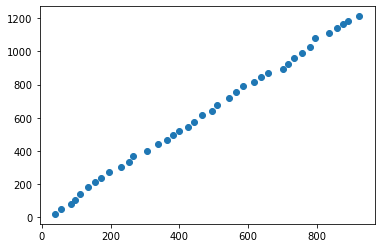

In [119]:
x = np.where(np.diff(np.argmax(ev_fmri.segments_[0], axis=1)))[0]
y = np.where(np.diff(np.argmax(ev_reservoir.segments_[0], axis=1)))[0]
plt.scatter(x,y)

In [33]:


#bounds = np.where(np.diff(np.argmax(ev_fmri.segments_[0], axis=1)))[0]

#h_bounds = np.where(np.diff(np.argmax(ev_reservoir.segments_[0], axis=1)))[0]
#h_bounds = h_bounds/1251*1976
#h_bounds = h_bounds/1251*946

for i in range(reps):
    bounds = fmri_bounds[i,:]
    h_bounds = reservoir_bounds_means/1251*946

    np.random.seed(1)

    event_counts = np.diff(np.concatenate(([0],bounds,[nTR])))
    nPerm = 1000
    perm_bounds = bounds
    threshold = 3

    match = np.zeros(nPerm+1)
    for p in range(nPerm+1):
        for hb in h_bounds:
            # check if match 
            if np.any(np.abs(perm_bounds - hb) <= threshold):
                match[p] += 1
        match[p] /= len(h_bounds)
        perm_counts = np.random.permutation(event_counts)
        perm_bounds = np.cumsum(perm_counts)[:-1]

    #plt.figure(figsize=(2,4))
    #plt.violinplot(match[1:], showextrema=False)
    #plt.scatter(1, match[0])
    #plt.gca().xaxis.set_visible(False)
    #plt.ylabel('Human-model match')
    print('p = ' + str(norm.sf((match[0]-match[1:].mean())/match[1:].std())))

p = 0.014241432218094617
p = 0.1176454175869256
p = 0.006227730497975162
p = 0.00019575260870755397
p = 0.5242868454344466
p = 0.004322255186094082
p = 0.0117582669571324
p = 0.00245371958249586
p = 0.13683962583226228
p = 0.000599974002970146
p = 0.15538517147756864
p = 0.2414091047124557
p = 0.12842470746040696
p = 0.06587047246900114
p = 0.35618796202090597
p = 0.06437928680027037


p = 0.0012180963798412712
[0.41025641 0.28205128 0.30769231 ... 0.30769231 0.23076923 0.25641026]


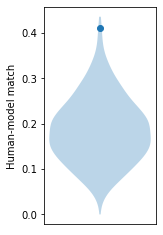

In [34]:

#np.random.seed(1)
#bounds = np.where(np.diff(np.argmax(ev_fmri.segments_[0], axis=1)))[0]

#h_bounds = np.where(np.diff(np.argmax(ev_reservoir.segments_[0], axis=1)))[0]
#h_bounds = h_bounds/1251*1976
#h_bounds = h_bounds/1251*946

h_bounds = fmri_bounds_means
bounds = reservoir_bounds_means/1251*946

np.random.seed(2)

event_counts = np.diff(np.concatenate(([0],bounds,[nTR])))
nPerm = 1000
perm_bounds = bounds
threshold = 3

match = np.zeros(nPerm+1)
for p in range(nPerm+1):
    for hb in h_bounds:
        # check if match 
        if np.any(np.abs(perm_bounds - hb) <= threshold):
            match[p] += 1
    match[p] /= len(h_bounds)
    perm_counts = np.random.permutation(event_counts)
    perm_bounds = np.cumsum(perm_counts)[:-1]

plt.figure(figsize=(2,4))
plt.violinplot(match[1:], showextrema=False)
plt.scatter(1, match[0])
plt.gca().xaxis.set_visible(False)
plt.ylabel('Human-model match')
print('p = ' + str(norm.sf((match[0]-match[1:].mean())/match[1:].std())))
print(match)

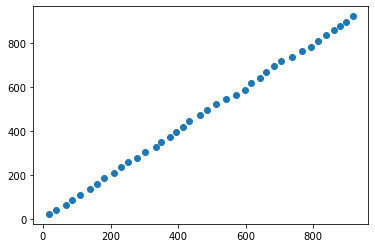

In [35]:
plt.scatter(bounds,h_bounds)

In [36]:
#fmri_bounds
#reservoir_bounds/682*400
i=0
for i in range(10):
    correlation, p_value = stats.pearsonr(fmri_bounds[i], reservoir_bounds[i])
    print('correltion: ',correlation)
    print('p_value: ', p_value)


correltion:  0.9994427549222964
p_value:  3.0465357351409188e-56
correltion:  0.9991894935528236
p_value:  3.111947367659816e-53
correltion:  0.9996398155159403
p_value:  9.514235976948721e-60
correltion:  0.9994211279952553
p_value:  6.160982092719273e-56
correltion:  0.9988498211165757
p_value:  2.0135947017249695e-50
correltion:  0.9989560109861897
p_value:  3.3579177108847744e-51
correltion:  0.9993446806180298
p_value:  6.109109157097197e-55
correltion:  0.9994578069631499
p_value:  1.8359164425202105e-56
correltion:  0.999036878050285
p_value:  7.561200221263022e-52
correltion:  0.9995813681915725
p_value:  1.535842914420601e-58


In [37]:
#reservoir_averages=np.load('Exp2-sherlock-res-40.npy')
#fmri_averages=np.load('Exp2-sherlock-fmri-40.npy')



In [38]:
#reservoir_bounds = np.load('Exp2-sherlock-res-bounds-40.npy')
#fmri_bounds= np.load('Exp2-sherlock-fmri-bounds-40.npy')

In [39]:
# get the mean bounds

print(reservoir_bounds.shape)
print(reservoir_bounds[:16,3])
print(reps)


(17, 39)
[105. 119. 105. 119. 120. 119. 109. 120. 119. 120. 120. 107. 120. 119.
 104. 120.]
16


In [40]:
segno=40  # k, or the number of segments we look for


In [41]:
print(reservoir_averages.shape)
print(fmri_averages.shape)

(1251, 1000)
(946, 4230)
